In [1]:
# Import packages

# Data analysis
import numpy as np
import pandas as pd

# File management
import os
import shutil

# Image visualisation
import matplotlib.pyplot as plt

# Neural network
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Custom utilities
import utilities_for_vgg as vggutils

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# If TPU is available
try:
    # Detect TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())

except:
    tpu = None
    

# If TPU is defined
if tpu:
    # Initialise TPU
    tf.tpu.experimental.initialize_tpu_system(tpu)
    # Instantiate a TPU distribution strategy
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

else:
    # Or instanstiate available strategy
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
# Define constants

# Set seed for reproducibility
SEED = 0
# Set batch size for mini-batch gradient descent
BATCH_SIZE = 256
# Set number of epochs to train model
EPOCH_NUM = 50


In [4]:
# Store paths to base, train set and subset dirs
base_dir = "/kaggle/input/imagenet-object-localization-challenge/"
data_dir = base_dir + "ILSVRC/Data/CLS-LOC/"

# Fetch train set
raw_train_ds = tf.data.Dataset.list_files(data_dir + "train/n01*/*.JPEG", shuffle=False)

# Find size of train set
train_size = tf.data.experimental.cardinality(raw_train_ds).numpy()

# Shuffle train set
raw_train_ds = raw_train_ds.shuffle(train_size, reshuffle_each_iteration=False, seed=SEED)

print(f"Size of train set: {train_size}")

Size of train set: 164467


In [5]:
# Import and extract devel labels
devel_df = pd.read_csv(base_dir + "LOC_val_solution.csv")
y_devel = devel_df["PredictionString"].str.split(expand=True)[0]

# Select devel images belonging to subset of classes
keep = np.where(y_devel.str.startswith("n01").to_numpy())[0]
devel_files = np.array(os.listdir(data_dir + "val/"))[keep]

# Fetch devel set
devel_files = np.array([data_dir + "val/" + file for file in devel_files])
raw_devel_ds = tf.data.Dataset.list_files(devel_files, shuffle=False)

# Select labels belonging to subset of classes
y_devel = y_devel[y_devel.str.startswith("n01")].values

# Find size of devel set
devel_size = tf.data.experimental.cardinality(raw_devel_ds).numpy()

print(f"Size of devel set: {devel_size}")
print("Examples of labels:")
y_devel[:10]

Size of devel set: 6350
Examples of labels:


array(['n01514859', 'n01950731', 'n01910747', 'n01632458', 'n01806143',
       'n01817953', 'n01698640', 'n01669191', 'n01491361', 'n01828970'],
      dtype=object)

model building 

In [6]:
# Find class names from dir names
class_names = np.array(sorted([dir for dir in os.listdir(data_dir + "train/") if dir.startswith("n01")]))

# Set number of classes
CLASS_NUM = len(class_names)

for f in raw_train_ds.take(5):
    print(f.numpy())

b'/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01689811/n01689811_5997.JPEG'
b'/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01693334/n01693334_8633.JPEG'
b'/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01847000/n01847000_1697.JPEG'
b'/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01682714/n01682714_14866.JPEG'
b'/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01667114/n01667114_8210.JPEG'


tf.Tensor(8, shape=(), dtype=int64)


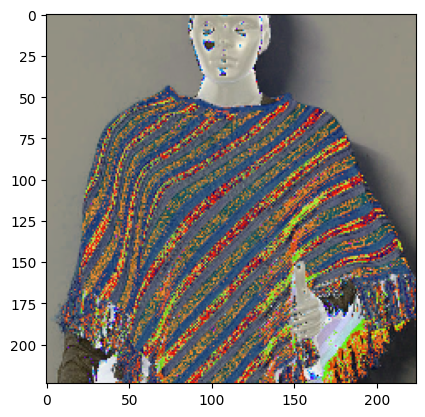

In [7]:
image, label = vggutils.process_path(
    data_dir + "val/ILSVRC2012_val_00046886.JPEG",
    class_names,
    devel_files,
    y_devel,
    label_fun=vggutils.extract_devel_label
)

input_shape = image.shape

plt.imshow(image)
print(label)

Train a CNN (11 layers at first). Specifically: 
train using minibatch gradient descent (size 256), backpropagation w momentum. 
the learning rate (start at 10-2) decreased 3 times, and the learning stopped after 370K iterations (74 epochs).
L2 regularization, penalty multiplier set to 5 · 10−4 
Dropout regularization 
Weight initialization (paragraph 3.1: Training)  is random for shallow network and then weights are transferred to deeper model (LR didn’t change for transferred theta values once transferred to deeper model). 
Training image size: S =  384 and S = 256. Isotropical rescale: It means apply the same scaling factor along width and height, so the image doesn't become distorted along one axis.


docs for: 

**tf.keras.layers.Dense(**
    units,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    ** kwargs
)

and 

**keras.layers.Conv2D** ( filters,
    kernel_size,
    strides=(1, 1),
    padding='valid',
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    ** kwargs

and 

**tf.keras.layers.MaxPooling2D**(
    pool_size=(2, 2),
    strides=None,
    padding='valid',
    data_format=None,
    **kwargs
)

In [8]:
# Preprocess train set
train_ds = raw_train_ds.map(
    lambda path: vggutils.process_path(path, class_names, devel_files, y_devel, label_fun=vggutils.extract_train_label),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Preprocess devel set
devel_ds = raw_devel_ds.map(
    lambda path: vggutils.process_path(path, class_names, devel_files, y_devel, label_fun=vggutils.extract_train_label, max_delta=0),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Show example
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  44


In [9]:
# Improve train set performance
train_ds = train_ds \
    .cache() \
    .shuffle(buffer_size=1000, seed=SEED) \
    .batch(BATCH_SIZE) \
    .prefetch(buffer_size=tf.data.AUTOTUNE)

# Improve devel set performance
devel_ds = devel_ds \
    .batch(BATCH_SIZE) \
    .cache() \
    .prefetch(buffer_size=tf.data.AUTOTUNE)

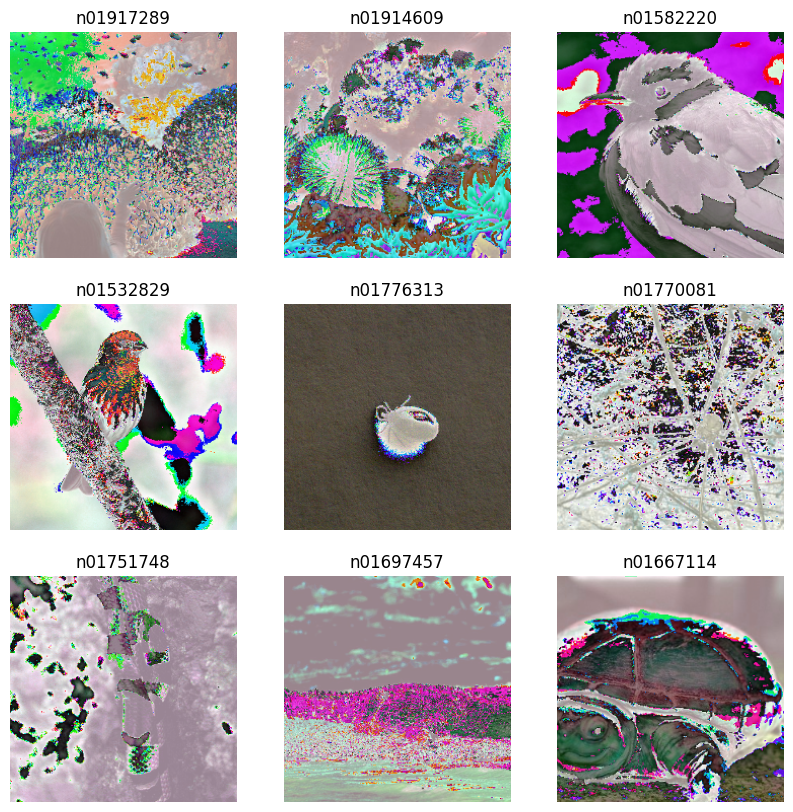

In [10]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

# Transfer Learning from VGG11

In [11]:
#Transfer Learning
# Import pretrained base
model_file = "/kaggle/input/11-layer-3-class/3class_model.keras"

# Save model into file for replication purposes

new_model = tf.keras.models.load_model(model_file)

# IMPORTANT: Set weights from base as untrainable
new_model.trainable = True

OSError: No file or directory found at /kaggle/input/11-layer-3-class/3class_model.keras

In [ ]:
# List indices of relevant layers (only convolutional, no maxpool)
layer_positions = [0, 2, 4, 5, 14, 16, 18]

# Select relevant layers
pretrained_layers = [new_model.get_layer(index=i) for i in layer_positions]

In [ ]:
#Build 19 layer model
def design_vgg19():

    model = tf.keras.models.Sequential()

    model.add(pretrained_layers[0]) #conv3-64 layer 1
    model.add(layers.Conv2D(64, (3, 3), activation='relu',padding= "same", name='19_layer_2' )) #conv3-64 layer 2
    model.add(layers.MaxPooling2D((2, 2), strides = (2,2))) #maxpool 1

    model.add(pretrained_layers[1]) #conv3-128 layer 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu',padding= "same", name='19_layer_4' )) #conv3-128 layer 4
    model.add(layers.MaxPooling2D((2, 2), strides = (2,2))) #maxpool 2

    model.add(pretrained_layers[2]) #conv3-256 layer 5
    model.add(pretrained_layers[3]) #conv3-256 layer 6
    model.add(layers.Conv2D(256, (3, 3), activation='relu',padding= "same", name='19_layer_7' )) #conv3-256 layer 7
    model.add(layers.Conv2D(256, (3, 3), activation='relu',padding= "same", name='19_layer_8' )) #conv3-256 layer 8
    model.add(layers.MaxPooling2D((2, 2), strides = (2,2))) #maxpool 3

    model.add(layers.Conv2D(512, (3, 3), activation='relu',padding= "same", name='19_layer_9')) #conv3-512 layer 9
    model.add(layers.Conv2D(512, (3, 3), activation='relu',padding= "same", name='19_layer_10')) #conv3-512 layer 10
    model.add(layers.Conv2D(512, (3, 3), activation='relu',padding= "same", name='19_layer_11')) #conv3-512 layer 11
    model.add(layers.Conv2D(512, (3, 3), activation='relu',padding= "same", name='19_layer_12')) #conv3-512 layer 12
    model.add(layers.MaxPooling2D((2, 2), strides = (2,2))) #maxpool 4

    model.add(layers.Conv2D(512, (3, 3), activation='relu',padding= "same", name='19_layer_13')) #conv3-512 layer 13
    model.add(layers.Conv2D(512, (3, 3), activation='relu',padding= "same", name='19_layer_14')) #conv3-512 layer 14
    model.add(layers.Conv2D(512, (3, 3), activation='relu',padding= "same", name='19_layer_15')) #conv3-512 layer 15
    model.add(layers.Conv2D(512, (3, 3), activation='relu',padding= "same", name='19_layer_16')) #conv3-512 layer 16
    model.add(layers.MaxPooling2D((2, 2), strides = (2,2))) #maxpool 5 - final

    model.add(layers.Flatten()) #necessary for 1D Dense layer
    model.add(pretrained_layers[4]) # FC 1 layer 17
    model.add(layers.Dropout(0.5))
    model.add(pretrained_layers[5]) #FC 2 layer 18
    model.add(layers.Dropout(0.5))
    model.add(pretrained_layers[6]) # FC 3 layer 19

In [ ]:
# Set up model within scope of tpu strategy
with strategy.scope():
    
    # Make environment more reproducible
    vggutils.reproduce_environment(random_state=SEED)
    
    # Build model
    model = design_vgg19()
    
    # Define optimiser
    sgd_optimiser = vggutils.create_optimiser()
    
    # Compile model
    model.compile(
        optimizer = sgd_optimiser,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["sparse_categorical_accuracy"]
    )

In [ ]:
# Update learning rate
LR_Decay = keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=2,
    mode="min",
    min_delta=1e-4,
    min_lr=1e-5
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=devel_ds,
    epochs=EPOCH_NUM,
    batch_size=BATCH_SIZE,
    verbose=True,
    callbacks=[LR_Decay]
)

# Store training history as a dataframe
history_df = pd.DataFrame(history.history)

print(f"Train loss: {history_df['loss'].iloc[-1]:.3f}, Devel loss: {history_df['val_loss'].iloc[-1]:.3f}")
print(f"Train accuracy: {history_df['sparse_categorical_accuracy'].iloc[-1]:.3f}, Devel accuracy: {history_df['val_sparse_categorical_accuracy'].iloc[-1]:.3f}")

In [ ]:
# Visualise loss
history_df.loc[:, ["loss", "val_loss"]].plot(title="Loss")

In [ ]:
# Visualise accuracy
history_df.loc[:, ["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot(title="Accuracy")